[<font size="5">Description of COVID-19 Detection Problem</font>](#1)

Five times more deadly than the flu, COVID-19 causes significant morbidity and mortality. Like other pneumonias, pulmonary infection with COVID-19 results in inflammation and fluid in the lungs. COVID-19 looks very similar to other viral and bacterial pneumonias on chest radiographs, which makes it difficult to diagnose. This computer vision model for detection and localization of COVID-19 would help doctors provide a quick and confident diagnosis. As a result, patients could get the right treatment before the most severe effects of the virus take hold.

Currently, COVID-19 can be diagnosed via polymerase chain reaction to detect genetic material from the virus or chest radiograph. However, it can take a few hours and sometimes days before the molecular test results are back. By contrast, chest radiographs can be obtained in minutes. While guidelines exist to help radiologists differentiate COVID-19 from other types of infection, their assessments vary. In addition, non-radiologists could be supported with better localization of the disease, such as with a visual bounding box.

In this competition, the task is to identify and localize COVID-19 abnormalities on chest radiographs. In particular, categorization of the radiographs as negative for pneumonia or typical, indeterminate, or atypical for COVID-19.

In [1]:
#first we import some important libraries
import numpy as np #for using arrays and matrices
import pandas as pd #for converting files to dataframe format, opening for example 
import matplotlib #for plotting graphs and tables
import matplotlib.pyplot as plt
import pydicom as dicom # Dicom (Digital Imaging) 
import os #allows us to use the operating system interation
from tqdm import tqdm # allows you to output a smart progress bar by wrapping around any iterable

<font size="5">Category of Radiographs </font>


1. NEGATIVE FOR PNEUMONIA - No lung opacities

2. TYPICAL APPEARANCE - Multifocal bilateral, peripheral opacities with rounded morphology, lower lung–predominant distribution

3. INDETERMINATE APPEARANCE - Absence of typical findings AND unilateral, central or upper lung predominant distribution

4. ATYPICAL APPEARANCE - Pneumothorax, pleural effusion, pulmonary edema, lobar consolidation, solitary lung nodule or mass, diffuse tiny nodules, cavity

<font size ="5"> Data Files </font>


1. train_study_level.csv - the train study-level metadata, with one row for each study, including correct labels.
    
2. train_image_level.csv - the train image-level metadata, with one row for each image, including both correct labels and any bounding boxes in a dictionary format. Some images in both test and train have multiple bounding boxes.
    
3. sample_submission.csv - a sample submission file containing all image- and study-level IDs.

4. train folder - comprises 6334 chest scans in DICOM format, stored in paths with the form study/series/image
    
5. test folder - The hidden test dataset is of roughly the same scale as the training dataset. Studies in the test set may contain more than one label.

[<font size="5">Interpretating the Problem </font>](#2)

The problem is about classification and detection and we are told to find in a test set, a *bounding box*, which is a rectangular box for identifying or even, detecting where a certain object is, and also it's said to find a class.
With the labels 'Negative for Pneumonia' 'Typical Appearance' 'Indeterminate Appearance' 'Atypical Appearance', we have to make a prediction string, for example:
> atypical 1 0 0 1 1


In [2]:
path = '/kaggle/input/siim-covid19-detection/'
train_image_level = pd.read_csv(path + "train_image_level.csv")


In [3]:
identity = train_image_level["id"] #we will write an specific column, in this case id
print(identity)

#if we wanted to show the first two columns we would use train_image_level["id", "boxes"]



0       000a312787f2_image
1       000c3a3f293f_image
2       0012ff7358bc_image
3       001398f4ff4f_image
4       001bd15d1891_image
               ...        
6329    ffcc6edd9445_image
6330    ffd91a2c4ca0_image
6331    ffd9b6cf2961_image
6332    ffdc682f7680_image
6333    ffe942c8655f_image
Name: id, Length: 6334, dtype: object


In [4]:
train_image_level.describe()
train_image_level.head(8) #we show the first 8 lines


,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e
5,0022227f5adf_image,"[{'x': 1857.2065, 'y': 508.30565, 'width': 376...",opacity 1 1857.2065 508.30565 2233.23384 907.8...,84543edc24c2
6,0023f02ae886_image,NaN,none 1 0 0 1 1,2fa400b873f5
7,002e9b2128d0_image,"[{'x': 276.72917, 'y': 627.42968, 'width': 910...",opacity 1 276.72917 627.42968 1187.31776 2283....,0717c8ac304f


In [5]:
train_image_level.loc[0,:] #for showing the first row in all columsn
#train_image_level.loc[row, column]


id                                                 000a312787f2_image
boxes               [{'x': 789.28836, 'y': 582.43035, 'width': 102...
label               opacity 1 789.28836 582.43035 1815.94498 2499....
StudyInstanceUID                                         5776db0cec75
Name: 0, dtype: object

[<font size="5">Plotting in the Graphic Form </font>](#3)

In [6]:
#extraction of an image 

def extract_image(i):
    path_train = path + 'train/' + training_set.loc[i, 'StudyInstanceUID']
    last_folder_in_path = os.listdir(path_train)[0]
    path_train = path_train + '/{}/'.format(last_folder_in_path)
    img_id = training_set.loc[i, 'id_y'].replace('_image','.dcm')
    print(img_id)
    data_file = dicom.dcmread(path_train + img_id)
    img = data_file.pixel_array
    return img

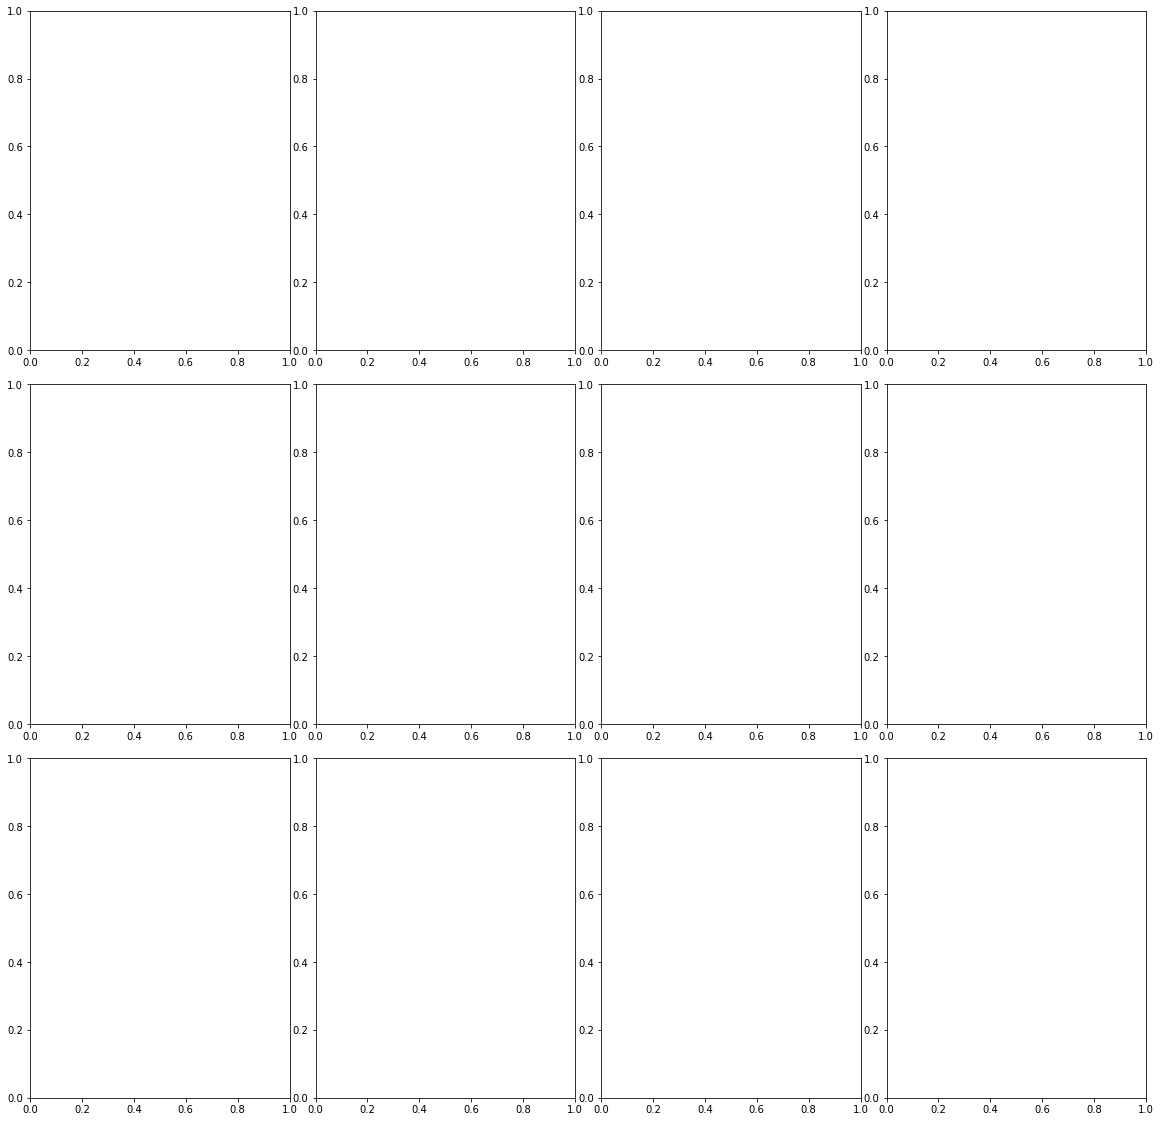

In [7]:
fig, axes = plt.subplots(3,4, figsize=(20,20)) #create 4 figures in horizontal and 3 in vertical with size (x,y) = (20,20)
fig.subplots_adjust(hspace=0.1, wspace=0.1) #(hspace, wspace) = (spacebetween two graphs in vertical, spacebetween two graphs in horizontal)

#above are some explanation for the plotting in the problem
#observe that figures are blank


In [8]:
train_study_level = pd.read_csv(path + "train_study_level.csv")
train_study_level_key = train_study_level.id.str[:-6]
training_set = pd.merge(left = train_study_level, right = train_image_level, how = 'right', left_on = train_study_level_key, right_on = 'StudyInstanceUID')
training_set.drop(['id_x'], axis = 1)


,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,id_y,boxes,label,StudyInstanceUID
0,0,1,0,0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,1,0,0,0,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0,1,0,0,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,0,0,0,1,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,0,1,0,0,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e
...,...,...,...,...,...,...,...,...
6329,1,0,0,0,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6330,1,0,0,0,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6331,0,1,0,0,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814
6332,0,1,0,0,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d


In [9]:
training_set.head()

,id_x,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,id_y,boxes,label,StudyInstanceUID
0,5776db0cec75_study,0,1,0,0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,ff0879eb20ed_study,1,0,0,0,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,9d514ce429a7_study,0,1,0,0,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,28dddc8559b2_study,0,0,0,1,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,dfd9fdd85a3e_study,0,1,0,0,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [10]:
training_set.loc[0,'label'] #we show the row 0 with column label


'opacity 1 789.28836 582.43035 1815.94498 2499.73327 opacity 1 2245.91208 591.20528 3340.5737 2352.75472'

In [11]:
#for a generic axes ax we have the following important functions

#ax.set_xticklabels([]) #ticks just denoting data points on axes in this case [] blank
#ax.set_yticklabels([]) #ticks just denoting data points on axes in this case [] blanck